In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.integrate import odeint
from sklearn import metrics
from random import shuffle

#Kinetic Characterization of Biomass
# Dilute Sulfuric Acid Hydrolysis:
# Mixtures of Hardwoods, Softwood,
# and Switchgrass

30.18711839245957
mean abs error:  30.18711839245957


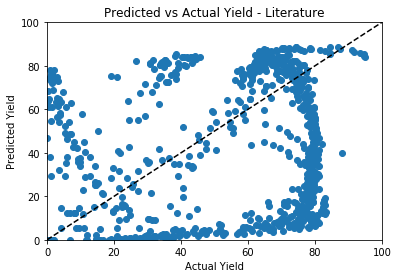

In [7]:
def getK (A, E, Ca, m, T):
    #A in min-1, E in kJ/mol, Ca in %, T in K
    if Ca > 0:
        return A * Ca ** m * math.exp(-E/(8.3143e-3 * T))
    else:
        return A * math.exp(-E/(8.3143e-3 * T))


def f(y, t):
    X = y[0]
    H = y[1]
    f0 = k1 * H - k2 * X ##Xylose
    f1 = -k1*H ##Xylose in solids
    return [f0, f1]


data = pd.read_csv("data.csv")
data = data.sample(frac=1).reset_index(drop=True)
data['Yield2'] = data['Yield']


for i in data.index:
#for i in range(1):
    #converting mol proton/L to % (assuming sulfuric Acid)
    weightPer = data.at[i, 'CA'] * 98.079 / 2 / 10
    #m = 1.75 for formation, 1 for degradation unless otherwise given

    #print(k1, k2)
    
    # initial conditions
    X0 = 0
    H0 = (data.at[i, 'F_X'] / 100)/(data.at[i, 'LSR'] + 1) * 1000
    #print(H0)
    y0 = [X0, H0]     # initial condition vector
    t  = np.linspace(0, data.at[i, 'IsoT'], num=100)
    
    
    #Iterating through parameters to find best one
    xs = []
#     A1 = [4.67e16, 2.19e8, 7.73e19, 3.18e15, 4.10e15]
#     E1 = [142.58, 76.19, 171.20, 133.44, 141.3]
#     A2 = [6.51e16, 7.59e15, 2.52e13, 6,83e13, 3.73e17]
#     E2 = [155.36, 147.56, 126.89, 129.64, 169.59]
    A1 = 4.67e16
    E1 = 142.58
    A2 = 6.51e16
    E2 = 155.36
#     for j in range(len(A1)):
#         k1 = getK(A=A1[j], E=E1[j], Ca=weightPer, m=1.75, T=data.at[i, 'Temp'])
#         k2 = getK(A=A2[j], E=E2[j], Ca=weightPer, m=1, T=data.at[i, 'Temp'])
#         soln = odeint(f, y0, t)
#         X_sol = soln[-1, 0]
#         xs.append(X_sol)
#         H_sol = soln[-1, 1]
    
#     best_X = min(xs, key=lambda x:abs(x-data.at[i, 'Yield']))

    k1 = getK(A=A1, E=E1, Ca=weightPer, m=1.75, T=data.at[i, 'Temp'])
    k2 = getK(A=A2, E=E2, Ca=weightPer, m=1, T=data.at[i, 'Temp'])
    soln = odeint(f, y0, t)
    X_sol = soln[-1, 0]
    xs.append(X_sol)
    H_sol = soln[-1, 1]
    
    #plt.plot(t, soln[:, 0], label='X')
    #plt.plot(t, soln[:, 1], label='H')
    #plt.legend()
    #print(t)
    #print(X_sol)
    #print(i)

    data.at[i, 'Yield2'] = 100 * X_sol * data.at[i, 'LSR'] / (1000 * (data.at[i, 'F_X']/100))
    
error = metrics.mean_absolute_error(data['Yield'], data['Yield2'])
print(error)

#data['Yield2'].plot(kind='hist')
plt.scatter(data['Yield'], data['Yield2'])   
t = np.linspace(0, 100, 400)
line = t
plt.plot(t, line, 'k', ls='dashed')

# plt.ylim(np.min((np.min([np.min(y_test), np.min(y_pred)]))), np.max((np.max([np.max(y_test), np.max(y_pred)]))))
# plt.xlim(np.min((np.min([np.min(y_test), np.min(y_pred)]))), np.max((np.max([np.max(y_test), np.max(y_pred)]))))
plt.ylim(0, 100)
plt.xlim(0, 100)


plt.xlabel("Actual Yield")
plt.ylabel('Predicted Yield')
plt.title("Predicted vs Actual Yield - Literature")


plt.savefig("LitEq.png", dpi=600, bbox_inches='tight')


print("mean abs error: ", error)

calc error is:  42.71455609632022
actual error is:  42.71455609632022
[4.6700e+16 1.4258e+02 1.7500e+00 6.5100e+16 1.5536e+02 1.0000e+00]


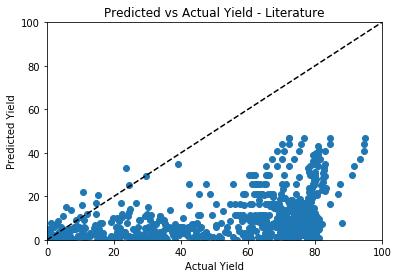

In [8]:
##Parameter Fitting
from sklearn import metrics
from openpyxl import Workbook
from openpyxl import load_workbook
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.integrate import odeint
from scipy import optimize

def getK (A, E, Ca, m, T):
    #A in min-1, E in kJ/mol, Ca in %, T in K
    if Ca > 0:
        return A * Ca ** m * math.exp(-E/(8.3143e-3 * T))
    else:
        return A * math.exp(-E/(8.3143e-3 * T))


def f(y, t):
    X = y[0]
    H = y[1]
    f0 = k1 * H - k2 * X ##Xylose
    f1 = -k1*H ##Xylose in solids
    return [f0, f1]


data = pd.read_csv("data.csv")
data = data.sample(frac=1).reset_index(drop=True)
data['Yield2'] = data['Yield']


def get_error(params):
    #Params are [A1, E1, m1, A2, E2, m2]
    for i in data.index:
    #for i in range(1):
        #converting mol proton/L to % (assuming sulfuric Acid)
        weightPer = data.at[i, 'CA'] * 98.079 / 2 / 10
        #m = 1.75 for formation, 1 for degradation unless otherwise given

        #print(k1, k2)

        # initial conditions
        X0 = 0
        H0 = (data.at[i, 'F_X'] / 100)/(data.at[i, 'LSR'] + 1) * 1000
        #print(H0)
        y0 = [X0, H0]     # initial condition vector

        #Solving System
        t  = np.linspace(0, data.at[i, 'IsoT'], num=100)
        A1, E1, m1, A2, E2, m2 = params
        k1 = getK(A=A1, E=E1, Ca=weightPer, m=m1, T=data.at[i, 'Temp'])
        k2 = getK(A=A2, E=E2, Ca=weightPer, m=m2, T=data.at[i, 'Temp'])
        soln = odeint(f, y0, t)
        X_sol = soln[-1, 0]
        H_sol = soln[-1, 1]
        
        data.at[i, 'Yield2'] = 100 * X_sol * data.at[i, 'LSR'] / (1000 * (data.at[i, 'F_X']/100))
        
    error = metrics.mean_absolute_error(data['Yield'], data['Yield2'])
    return error
    

initalGuessParams = [4.67e16, 142.58, 1.75, 6.51e16, 155.36, 1]

output = optimize.fmin(get_error, initalGuessParams, maxiter=3, full_output=1)
# output = optimize.fmin_powell(get_error, initalGuessParams, full_output=True)
# output = optimize.fmin_cg(get_error, initalGuessParams, full_output=True)


minimum = output[0]
errors = output[1]
print("calc error is: ", errors)

actualError = get_error(minimum)
print("actual error is: ", actualError)


bestA1, bestE1, bestm1, bestA2, bestE2, bestm2 = minimum

print(minimum)

# for i in data.index:
#     #for i in range(1):
#         #converting mol proton/L to % (assuming sulfuric Acid)
#         weightPer = data.at[i, 'CA'] * 98.079 / 2 / 10

#         # initial conditions
#         X0 = 0
#         H0 = (data.at[i, 'F_X'] / 100)/(data.at[i, 'LSR'] + 1) * 1000
#         y0 = [X0, H0]     # initial condition vector

#         #Solving System
#         t  = np.linspace(0, data.at[i, 'IsoT'], num=100)
#         k1 = getK(A=bestA1, E=bestE1, Ca=weightPer, m=bestm1, T=data.at[i, 'Temp'])
#         k2 = getK(A=bestA2, E=bestE2, Ca=weightPer, m=bestm2, T=data.at[i, 'Temp'])
#         soln = odeint(f, y0, t)
#         X_sol = soln[-1, 0]
#         H_sol = soln[-1, 1]
        
#         data.at[i, 'Yield2'] = 100 * X_sol * data.at[i, 'LSR'] / (1000 * (data.at[i, 'F_X']/100))

plt.scatter(data['Yield'], data['Yield2']) 
t = np.linspace(0, 100, 400)
line = t
plt.plot(t, line, 'k', ls='dashed')


plt.ylim(0, 100)
plt.xlim(0, 100)


plt.xlabel("Actual Yield")
plt.ylabel('Predicted Yield')
plt.title("Predicted vs Actual Yield - Literature")


plt.savefig("LitEq2.png", dpi=600, bbox_inches='tight')


Optimization terminated successfully.
         Current function value: 42.714556
         Iterations: 1
         Function evaluations: 73
calc error is:  42.71455609632024
actual error is:  42.71455609632024
[4.67000000e+16 1.45167929e+02 4.33792896e+00 6.51000000e+16
 1.57947929e+02 3.58792896e+00]


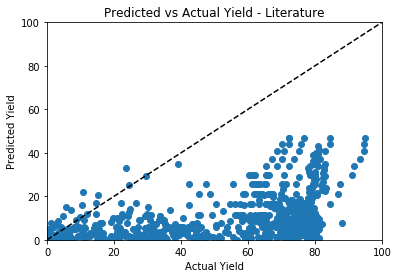

In [9]:
##Parameter Fitting
from sklearn import metrics
from openpyxl import Workbook
from openpyxl import load_workbook
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.integrate import odeint
from scipy import optimize

def getK (A, E, Ca, m, T):
    #A in min-1, E in kJ/mol, Ca in %, T in K
    if Ca > 0:
        return A * Ca ** m * math.exp(-E/(8.3143e-3 * T))
    else:
        return A * math.exp(-E/(8.3143e-3 * T))


def f(y, t):
    X = y[0]
    H = y[1]
    f0 = k1 * H - k2 * X ##Xylose
    f1 = -k1*H ##Xylose in solids
    return [f0, f1]


data = pd.read_csv("data.csv")
data = data.sample(frac=1).reset_index(drop=True)
data['Yield2'] = data['Yield']


def get_error(params):
    #Params are [A1, E1, m1, A2, E2, m2]
    for i in data.index:
    #for i in range(1):
        #converting mol proton/L to % (assuming sulfuric Acid)
        weightPer = data.at[i, 'CA'] * 98.079 / 2 / 10
        #m = 1.75 for formation, 1 for degradation unless otherwise given

        #print(k1, k2)

        # initial conditions
        X0 = 0
        H0 = (data.at[i, 'F_X'] / 100)/(data.at[i, 'LSR'] + 1) * 1000
        #print(H0)
        y0 = [X0, H0]     # initial condition vector

        #Solving System
        t  = np.linspace(0, data.at[i, 'IsoT'], num=100)
        A1, E1, m1, A2, E2, m2 = params
        k1 = getK(A=A1, E=E1, Ca=weightPer, m=m1, T=data.at[i, 'Temp'])
        k2 = getK(A=A2, E=E2, Ca=weightPer, m=m2, T=data.at[i, 'Temp'])
        soln = odeint(f, y0, t)
        X_sol = soln[-1, 0]
        H_sol = soln[-1, 1]
        
        data.at[i, 'Yield2'] = 100 * X_sol * data.at[i, 'LSR'] / (1000 * (data.at[i, 'F_X']/100))
        
    error = metrics.mean_absolute_error(data['Yield'], data['Yield2'])
    return error
    

initalGuessParams = [4.67e16, 142.58, 1.75, 6.51e16, 155.36, 1]

# output = optimize.fmin(get_error, initalGuessParams, maxiter=3, full_output=1)
output = optimize.fmin_powell(get_error, initalGuessParams, full_output=True)
# output = optimize.fmin_cg(get_error, initalGuessParams, full_output=True)


minimum = output[0]
errors = output[1]
print("calc error is: ", errors)

actualError = get_error(minimum)
print("actual error is: ", actualError)


bestA1, bestE1, bestm1, bestA2, bestE2, bestm2 = minimum

print(minimum)

# for i in data.index:
#     #for i in range(1):
#         #converting mol proton/L to % (assuming sulfuric Acid)
#         weightPer = data.at[i, 'CA'] * 98.079 / 2 / 10

#         # initial conditions
#         X0 = 0
#         H0 = (data.at[i, 'F_X'] / 100)/(data.at[i, 'LSR'] + 1) * 1000
#         y0 = [X0, H0]     # initial condition vector

#         #Solving System
#         t  = np.linspace(0, data.at[i, 'IsoT'], num=100)
#         k1 = getK(A=bestA1, E=bestE1, Ca=weightPer, m=bestm1, T=data.at[i, 'Temp'])
#         k2 = getK(A=bestA2, E=bestE2, Ca=weightPer, m=bestm2, T=data.at[i, 'Temp'])
#         soln = odeint(f, y0, t)
#         X_sol = soln[-1, 0]
#         H_sol = soln[-1, 1]
        
#         data.at[i, 'Yield2'] = 100 * X_sol * data.at[i, 'LSR'] / (1000 * (data.at[i, 'F_X']/100))

plt.scatter(data['Yield'], data['Yield2']) 
t = np.linspace(0, 100, 400)
line = t
plt.plot(t, line, 'k', ls='dashed')

plt.ylim(0, 100)
plt.xlim(0, 100)


plt.xlabel("Actual Yield")
plt.ylabel('Predicted Yield')
plt.title("Predicted vs Actual Yield - Literature")

plt.savefig("LitEq3.png", dpi=600, bbox_inches='tight')


Optimization terminated successfully.
         Current function value: 42.714556
         Iterations: 0
         Function evaluations: 8
         Gradient evaluations: 1
calc error is:  42.71455609632022
actual error is:  42.71455609632022
[4.6700e+16 1.4258e+02 1.7500e+00 6.5100e+16 1.5536e+02 1.0000e+00]


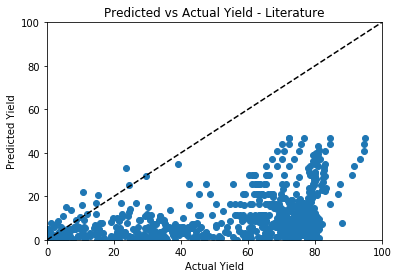

In [12]:
##Parameter Fitting
from sklearn import metrics
from openpyxl import Workbook
from openpyxl import load_workbook
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.integrate import odeint
from scipy import optimize

def getK (A, E, Ca, m, T):
    #A in min-1, E in kJ/mol, Ca in %, T in K
    if Ca > 0:
        return A * Ca ** m * math.exp(-E/(8.3143e-3 * T))
    else:
        return A * math.exp(-E/(8.3143e-3 * T))


def f(y, t):
    X = y[0]
    H = y[1]
    f0 = k1 * H - k2 * X ##Xylose
    f1 = -k1*H ##Xylose in solids
    return [f0, f1]


data = pd.read_csv("data.csv")
data = data.sample(frac=1).reset_index(drop=True)
data['Yield2'] = data['Yield']


def get_error(params):
    #Params are [A1, E1, m1, A2, E2, m2]
    for i in data.index:
    #for i in range(1):
        #converting mol proton/L to % (assuming sulfuric Acid)
        weightPer = data.at[i, 'CA'] * 98.079 / 2 / 10
        #m = 1.75 for formation, 1 for degradation unless otherwise given

        #print(k1, k2)

        # initial conditions
        X0 = 0
        H0 = (data.at[i, 'F_X'] / 100)/(data.at[i, 'LSR'] + 1) * 1000
        #print(H0)
        y0 = [X0, H0]     # initial condition vector

        #Solving System
        t  = np.linspace(0, data.at[i, 'IsoT'], num=100)
        A1, E1, m1, A2, E2, m2 = params
        k1 = getK(A=A1, E=E1, Ca=weightPer, m=m1, T=data.at[i, 'Temp'])
        k2 = getK(A=A2, E=E2, Ca=weightPer, m=m2, T=data.at[i, 'Temp'])
        soln = odeint(f, y0, t)
        X_sol = soln[-1, 0]
        H_sol = soln[-1, 1]
        
        data.at[i, 'Yield2'] = 100 * X_sol * data.at[i, 'LSR'] / (1000 * (data.at[i, 'F_X']/100))
        
    error = metrics.mean_absolute_error(data['Yield'], data['Yield2'])
    return error
    

initalGuessParams = [4.67e16, 142.58, 1.75, 6.51e16, 155.36, 1]

# output = optimize.fmin(get_error, initalGuessParams, maxiter=3, full_output=1)
# output = optimize.fmin_powell(get_error, initalGuessParams, full_output=True)
output = optimize.fmin_cg(get_error, initalGuessParams, full_output=True)


minimum = output[0]
errors = output[1]
print("calc error is: ", errors)

actualError = get_error(minimum)
print("actual error is: ", actualError)


bestA1, bestE1, bestm1, bestA2, bestE2, bestm2 = minimum

print(minimum)

# for i in data.index:
#     #for i in range(1):
#         #converting mol proton/L to % (assuming sulfuric Acid)
#         weightPer = data.at[i, 'CA'] * 98.079 / 2 / 10

#         # initial conditions
#         X0 = 0
#         H0 = (data.at[i, 'F_X'] / 100)/(data.at[i, 'LSR'] + 1) * 1000
#         y0 = [X0, H0]     # initial condition vector

#         #Solving System
#         t  = np.linspace(0, data.at[i, 'IsoT'], num=100)
#         k1 = getK(A=bestA1, E=bestE1, Ca=weightPer, m=bestm1, T=data.at[i, 'Temp'])
#         k2 = getK(A=bestA2, E=bestE2, Ca=weightPer, m=bestm2, T=data.at[i, 'Temp'])
#         soln = odeint(f, y0, t)
#         X_sol = soln[-1, 0]
#         H_sol = soln[-1, 1]
        
#         data.at[i, 'Yield2'] = 100 * X_sol * data.at[i, 'LSR'] / (1000 * (data.at[i, 'F_X']/100))

plt.scatter(data['Yield'], data['Yield2'])
t = np.linspace(0, 100, 400)
line = t
plt.plot(t, line, 'k', ls='dashed')


plt.ylim(0, 100)
plt.xlim(0, 100)


plt.xlabel("Actual Yield")
plt.ylabel('Predicted Yield')
plt.title("Predicted vs Actual Yield - Literature")

plt.savefig("LitEq4.png", dpi=600, bbox_inches='tight')



784
calc error is:  13.730562130807309
actual error is:  13.730562130807309
[4.51093455e+16 1.33337656e+02 1.46708352e+00 1.16783420e+17
 1.52344413e+02 8.17031350e-01]


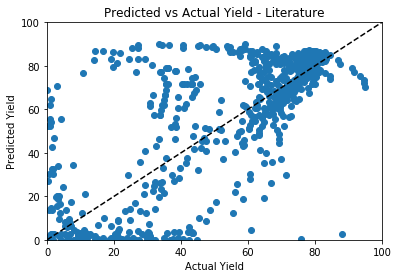

In [6]:
## Using algebraic solution instead of ODEINT
from sklearn import metrics
from openpyxl import Workbook
from openpyxl import load_workbook
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.integrate import odeint
from scipy import optimize



def getK (A, E, Ca, m, T):
    #A in min-1, E in kJ/mol, Ca in %, T in K
    if T > 450:
        T = 450
    if Ca > 0:
        return A * Ca ** m * math.exp(-E/(8.3143e-3 * T))
    else:
        return A * math.exp(-E/(8.3143e-3 * T))


data = pd.read_csv("data.csv")
data = data.sample(frac=1).reset_index(drop=True)
data['Yield2'] = data['Yield']


def getX(k1, k2, H0, t):
#     print(k1, k2, H0, t)
#     num = -k1 * H0 * math.exp(t* (-k1 - k2)) * (math.exp(k2*t) - math.exp(k1*t))

    num = -k1 * H0 * (math.exp(-k1*t) - math.exp(-k2*t))
    denom = k1 - k2
    return num/denom



print(len(data.index))
def get_error(params):
    #Params are [A1, E1, m1, A2, E2, m2]
    for i in data.index:
#         print(i)
    #for i in range(1):
        #converting mol proton/L to % (assuming sulfuric Acid)
        weightPer = data.at[i, 'CA'] * 98.079 / 2 / 10
        #m = 1.75 for formation, 1 for degradation unless otherwise given

        #print(k1, k2)
        
        A1, E1, m1, A2, E2, m2 = params

        # initial conditions
        X0 = 0
        H0 = (data.at[i, 'F_X'] / 100)/(data.at[i, 'LSR'] + 1) * 1000
        
        k1 = getK(A=A1, E=E1, Ca=weightPer, m=m1, T=data.at[i, 'Temp'])
#         print(A1, E1, m1, A2, E2, m2, data.at[i, 'Temp'], weightPer)
        k2 = getK(A=A2, E=E2, Ca=weightPer, m=m2, T=data.at[i, 'Temp'])

        X_sol = getX(k1=k1, k2=k2, H0=H0, t=data.at[i, 'IsoT'])
        
        data.at[i, 'Yield2'] = 100 * X_sol * data.at[i, 'LSR'] / (1000 * (data.at[i, 'F_X']/100))
        
    error = metrics.mean_absolute_error(data['Yield'], data['Yield2'])
    return error
    

initalGuessParams = [4.67e16, 142.58, 1.75, 6.51e16, 155.36, 1]

output = optimize.fmin(get_error, initalGuessParams, maxiter=100, full_output=1)
# output = optimize.fmin_powell(get_error, initalGuessParams, full_output=True)
# output = optimize.fmin_cg(get_error, initalGuessParams, full_output=True)


minimum = output[0]
errors = output[1]
print("calc error is: ", errors)

actualError = get_error(minimum)
print("actual error is: ", actualError)


bestA1, bestE1, bestm1, bestA2, bestE2, bestm2 = minimum


print(minimum)

plt.scatter(data['Yield'], data['Yield2']) 
t = np.linspace(0, 100, 400)
line = t
plt.plot(t, line, 'k', ls='dashed')


plt.ylim(0, 100)
plt.xlim(0, 100)


plt.xlabel("Actual Yield")
plt.ylabel('Predicted Yield')
plt.title("Predicted vs Actual Yield - Arrhenius")

plt.savefig("LitEqAlgebraic.png", dpi=600, bbox_inches='tight')


B
G
E
K
F
H
P
A
O
N
D
I
J
L
M
C


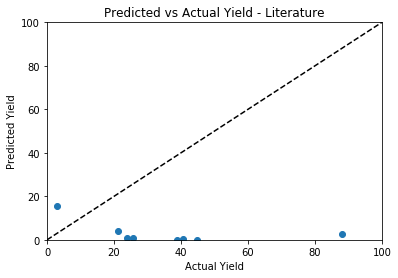

In [8]:
##Cross


## Using algebraic solution instead of ODEINT
from sklearn import metrics
from openpyxl import Workbook
from openpyxl import load_workbook
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.integrate import odeint
from scipy import optimize



def getK (A, E, Ca, m, T):
    #A in min-1, E in kJ/mol, Ca in %, T in K
    if T > 450:
        T = 450
    if Ca > 0:
        return A * Ca ** m * math.exp(-E/(8.3143e-3 * T))
    else:
        return A * math.exp(-E/(8.3143e-3 * T))


data = pd.read_csv("data.csv")
data = data.sample(frac=1).reset_index(drop=True)
data['Yield2'] = data['Yield']


papers = data['ID'].unique()
shuffle(papers)

error_Frame = pd.DataFrame(columns=['ID', 'LitEq'])

numPapers = len(papers)
papersPerGroup = 2
numBins = 10


combos = [papers[x:x + papersPerGroup] for x in range(0, len(papers), papersPerGroup)]
# error_Frame = pd.DataFrame(columns=['Source', 'Linear', 'Ridge', 'SVR'])

def getX(k1, k2, H0, t):
#     print(k1, k2, H0, t)
#     num = -k1 * H0 * math.exp(t* (-k1 - k2)) * (math.exp(k2*t) - math.exp(k1*t))

    num = -k1 * H0 * (math.exp(-k1*t) - math.exp(-k2*t))
    denom = k1 - k2
    return num/denom

def get_error(params):
    #Params are [A1, E1, m1, A2, E2, m2]
    for i in data.index:
#         print(i)
    #for i in range(1):
        #converting mol proton/L to % (assuming sulfuric Acid)
        weightPer = data.at[i, 'CA'] * 98.079 / 2 / 10
        #m = 1.75 for formation, 1 for degradation unless otherwise given

        #print(k1, k2)
        
        A1, E1, m1, A2, E2, m2 = params

        # initial conditions
        X0 = 0
        H0 = (data.at[i, 'F_X'] / 100)/(data.at[i, 'LSR'] + 1) * 1000
        
        k1 = getK(A=A1, E=E1, Ca=weightPer, m=m1, T=data.at[i, 'Temp'])
#         print(A1, E1, m1, A2, E2, m2, data.at[i, 'Temp'], weightPer)
        k2 = getK(A=A2, E=E2, Ca=weightPer, m=m2, T=data.at[i, 'Temp'])

        X_sol = getX(k1=k1, k2=k2, H0=H0, t=data.at[i, 'IsoT'])
        
        data.at[i, 'Yield2'] = 100 * X_sol * data.at[i, 'LSR'] / (1000 * (data.at[i, 'F_X']/100))
        
    error = metrics.mean_absolute_error(data['Yield'], data['Yield2'])
    return error
    

for paper in papers:
    print(paper)
    #Simple Linear Regr
    train_Frame = data[data['ID'] != paper]
    test_Frame = data[data['ID'] == paper]


    initalGuessParams = [4.67e16, 142.58, 1.75, 6.51e16, 155.36, 1]
    output = optimize.fmin(get_error, initalGuessParams, maxiter=100, full_output=1)
    minimum = output[0]
    
    bestA1, bestE1, bestm1, bestA2, bestE2, bestm2 = minimum
    
    for i in test_Frame.index:
        X0 = 0
        H0 = (test_Frame.at[i, 'F_X'] / 100)/(test_Frame.at[i, 'LSR'] + 1) * 1000
        weightPer = test_Frame.at[i, 'CA'] * 98.079 / 2 / 10
        k1 = getK(A=bestA1, E=bestE1, Ca=weightPer, m=bestm1, T=test_Frame.at[i, 'Temp'])

        k2 = getK(A=bestA2, E=bestE2, Ca=weightPer, m=bestm2, T=test_Frame.at[i, 'Temp'])

        X_sol = getX(k1=k1, k2=k2, H0=H0, t=test_Frame.at[i, 'IsoT'])
        
        test_Frame.at[i, 'Yield2'] = 100 * X_sol * test_Frame.at[i, 'LSR'] / (1000 * (test_Frame.at[i, 'F_X']/100))
        
    error = metrics.mean_absolute_error(test_Frame['Yield'], test_Frame['Yield2'])
    row = [[paper, error]]
    tempDf = pd.DataFrame(row, columns=['ID', 'LitEq'])
    error_Frame = pd.concat([error_Frame, tempDf], ignore_index=True)
    error_Frame.index = error_Frame['ID'].values
    error_Frame = error_Frame.sort_index()
    error_Frame.to_csv("CrossValidLitEq.csv")    

        

plt.scatter(test_Frame['Yield'], test_Frame['Yield2']) 
t = np.linspace(0, 100, 400)
line = t
plt.plot(t, line, 'k', ls='dashed')


plt.ylim(0, 100)
plt.xlim(0, 100)


plt.xlabel("Actual Yield")
plt.ylabel('Predicted Yield')
plt.title("Predicted vs Actual Yield - Literature")

plt.savefig("LitEqAlgebraic2.png", dpi=600, bbox_inches='tight')
    
error_Frame = error_Frame.sort_index()
error_Frame.to_csv("CrossValidLitEq.csv")    

    
    


# print(len(data.index))


# initalGuessParams = [4.67e16, 142.58, 1.75, 6.51e16, 155.36, 1]

# output = optimize.fmin(get_error, initalGuessParams, maxiter=100, full_output=1)
# # output = optimize.fmin_powell(get_error, initalGuessParams, full_output=True)
# # output = optimize.fmin_cg(get_error, initalGuessParams, full_output=True)


# minimum = output[0]
# errors = output[1]
# print("calc error is: ", errors)

# actualError = get_error(minimum)
# print("actual error is: ", actualError)


# bestA1, bestE1, bestm1, bestA2, bestE2, bestm2 = minimum


# print(minimum)

# plt.scatter(data['Yield'], data['Yield2']) 
# t = np.linspace(0, 100, 400)
# line = t
# plt.plot(t, line, 'k', ls='dashed')


# plt.ylim(0, 100)
# plt.xlim(0, 100)


# plt.xlabel("Actual Yield")
# plt.ylabel('Predicted Yield')
# plt.title("Predicted vs Actual Yield - Literature")

# plt.savefig("LitEqAlgebraic.png", dpi=600, bbox_inches='tight')



667
calc error is:  13.883716361847851
actual error is:  13.883716361847851
MAE 14.626560561774072
[4.11347896e+16 1.32729946e+02 1.74766939e+00 8.69720517e+16
 1.50970263e+02 7.30210421e-01]


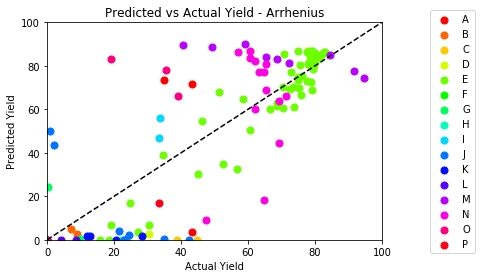

In [11]:
#Random Train Test Split


from sklearn import metrics
from openpyxl import Workbook
from openpyxl import load_workbook
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.integrate import odeint
from scipy import optimize



def getK (A, E, Ca, m, T):
    #A in min-1, E in kJ/mol, Ca in %, T in K
    if T > 450:
        T = 450
    if Ca > 0:
        return A * Ca ** m * math.exp(-E/(8.3143e-3 * T))
    else:
        return A * math.exp(-E/(8.3143e-3 * T))


data = pd.read_csv("data.csv")
data = data.sample(frac=1).reset_index(drop=True)
data['Yield2'] = data['Yield']


numData = len(data.index)
numTrain = int(numData * 0.7)
numTest = int(numData * .15) 
# print(numTest, numTrain)
train_Frame, valid_Frame, test_Frame, train_valid_Frame = data.iloc[:numTrain, :], data.iloc[numTrain:-numTest, :], data.iloc[-numTest:, :], data.iloc[:-numTest:, :]


def getX(k1, k2, H0, t):
#     print(k1, k2, H0, t)
#     num = -k1 * H0 * math.exp(t* (-k1 - k2)) * (math.exp(k2*t) - math.exp(k1*t))

    num = -k1 * H0 * (math.exp(-k1*t) - math.exp(-k2*t))
    denom = k1 - k2
    return num/denom



print(len(train_valid_Frame.index))
def get_error(params):
    #Params are [A1, E1, m1, A2, E2, m2]
    for i in train_valid_Frame.index:
#         print(i)
    #for i in range(1):
        #converting mol proton/L to % (assuming sulfuric Acid)
        weightPer = train_valid_Frame.at[i, 'CA'] * 98.079 / 2 / 10
        #m = 1.75 for formation, 1 for degradation unless otherwise given

        #print(k1, k2)
        
        A1, E1, m1, A2, E2, m2 = params

        # initial conditions
        X0 = 0
        H0 = (train_valid_Frame.at[i, 'F_X'] / 100)/(train_valid_Frame.at[i, 'LSR'] + 1) * 1000
        
        k1 = getK(A=A1, E=E1, Ca=weightPer, m=m1, T=train_valid_Frame.at[i, 'Temp'])
#         print(A1, E1, m1, A2, E2, m2, data.at[i, 'Temp'], weightPer)
        k2 = getK(A=A2, E=E2, Ca=weightPer, m=m2, T=train_valid_Frame.at[i, 'Temp'])

        X_sol = getX(k1=k1, k2=k2, H0=H0, t=train_valid_Frame.at[i, 'IsoT'])
        
        train_valid_Frame.at[i, 'Yield2'] = 100 * X_sol * train_valid_Frame.at[i, 'LSR'] / (1000 * (train_valid_Frame.at[i, 'F_X']/100))
        
    error = metrics.mean_absolute_error(train_valid_Frame['Yield'], train_valid_Frame['Yield2'])
    return error
    

initalGuessParams = [4.67e16, 142.58, 1.75, 6.51e16, 155.36, 1]

output = optimize.fmin(get_error, initalGuessParams, maxiter=100, full_output=1)
# output = optimize.fmin_powell(get_error, initalGuessParams, full_output=True)
# output = optimize.fmin_cg(get_error, initalGuessParams, full_output=True)


minimum = output[0]
errors = output[1]
print("calc error is: ", errors)

actualError = get_error(minimum)
print("actual error is: ", actualError)


bestA1, bestE1, bestm1, bestA2, bestE2, bestm2 = minimum

#Calculating based on test Frame

y_test = test_Frame['Yield']

y_pred = []

for i in test_Frame.index:
        weightPer = test_Frame.at[i, 'CA'] * 98.079 / 2 / 10

        X0 = 0
        H0 = (test_Frame.at[i, 'F_X'] / 100)/(test_Frame.at[i, 'LSR'] + 1) * 1000
        k1 = getK(A=bestA1, E=bestE1, Ca=weightPer, m=bestm1, T=test_Frame.at[i, 'Temp'])
#         print(A1, E1, m1, A2, E2, m2, data.at[i, 'Temp'], weightPer)
        k2 = getK(A=bestA2, E=bestE2, Ca=weightPer, m=bestm2, T=test_Frame.at[i, 'Temp'])

        X_sol = getX(k1=k1, k2=k2, H0=H0, t=test_Frame.at[i, 'IsoT'])
        
        test_Frame.at[i, 'Yield2'] = 100 * X_sol * test_Frame.at[i, 'LSR'] / (1000 * (test_Frame.at[i, 'F_X']/100))
        
        #y_pred.append(100 * X_sol * test_Frame.at[i, 'LSR'] / (1000 * (test_Frame.at[i, 'F_X']/100)))
        

        
error = metrics.mean_absolute_error(test_Frame['Yield'], test_Frame['Yield2'])
print("MAE", error)

y_pred = test_Frame['Yield2']

print(minimum)

targets = data['ID'].unique()
targets.sort()
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

colors = get_cmap(len(targets))

#plt.hist(error_arr)
#plt.scatter(y_test, y_pred)



for index, target in enumerate(targets):
    indicesToKeep = test_Frame['ID'] == target
    plt.scatter(y_test.values[indicesToKeep]
               , y_pred.values[indicesToKeep]
               , c = colors(index)
               , s = 50)
    
t = np.linspace(0, 100, 400)
line = t


plt.legend(targets, bbox_to_anchor=(1,0.5), loc=6, fontsize=10, 
           bbox_transform=plt.gcf().transFigure)
plt.plot(t, line, 'k', ls='dashed')


plt.ylim(0, 100)
plt.xlim(0, 100)

plt.xlabel("Actual Yield")
plt.ylabel('Predicted Yield')
plt.title("Predicted vs Actual Yield - Arrhenius")
plt.savefig("LitEqPred", dpi=600, bbox_inches='tight')



